In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/12-class-ssvep-eeg-data/s2.mat
/kaggle/input/12-class-ssvep-eeg-data/s5.mat
/kaggle/input/12-class-ssvep-eeg-data/s6.mat
/kaggle/input/12-class-ssvep-eeg-data/s10.mat
/kaggle/input/12-class-ssvep-eeg-data/s8.mat
/kaggle/input/12-class-ssvep-eeg-data/s7.mat
/kaggle/input/12-class-ssvep-eeg-data/s1.mat
/kaggle/input/12-class-ssvep-eeg-data/s3.mat
/kaggle/input/12-class-ssvep-eeg-data/s4.mat
/kaggle/input/12-class-ssvep-eeg-data/s9.mat


### SSVEP EEG dataset Classification Using CNNs

In [3]:
import sys
import os
import warnings
import numpy as np
import numpy.matlib as npm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import KFold

from tensorflow.keras.utils import to_categorical
from keras import optimizers
from keras.losses import categorical_crossentropy

import ssvep_ultils as su
warnings.filterwarnings('ignore')

/kaggle/input/12-class-ssvep-eeg-data/s2.mat
/kaggle/input/12-class-ssvep-eeg-data/s5.mat
/kaggle/input/12-class-ssvep-eeg-data/s6.mat
/kaggle/input/12-class-ssvep-eeg-data/s10.mat
/kaggle/input/12-class-ssvep-eeg-data/s8.mat
/kaggle/input/12-class-ssvep-eeg-data/s7.mat
/kaggle/input/12-class-ssvep-eeg-data/s1.mat
/kaggle/input/12-class-ssvep-eeg-data/s3.mat
/kaggle/input/12-class-ssvep-eeg-data/s4.mat
/kaggle/input/12-class-ssvep-eeg-data/s9.mat


In [4]:
def get_training_data(features_data):
    features_data = np.reshape(features_data, (features_data.shape[0], features_data.shape[1], 
                                               features_data.shape[2], 
                                               features_data.shape[3]*features_data.shape[4]))

    train_data = features_data[:, :, 0, :].T
    for target in range(1, features_data.shape[2]):
        train_data = np.vstack([train_data, np.squeeze(features_data[:, :, target, :]).T])

    train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 
                                         train_data.shape[2], 1))


    total_epochs_per_class = features_data.shape[3]
    class_labels = np.arange(CNN_PARAMS['num_classes'])
    labels = np.tile(class_labels, (total_epochs_per_class, 1)).T.ravel() 
    labels = to_categorical(labels)  
    
    return train_data, labels

In [5]:
def train_CNN_cross_val_predict(train_data, labels, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True)
    kf.get_n_splits(train_data)
    cv_acc = np.zeros((num_folds, 1))
    fold = -1

    for train_index, test_index in kf.split(train_data):
        x_tr, x_ts = train_data[train_index], train_data[test_index]
        y_tr, y_ts = labels[train_index], labels[test_index]
        input_shape = np.array([x_tr.shape[1], x_tr.shape[2], x_tr.shape[3]])
        
        fold = fold + 1
        
        model = su.CNN_model(input_shape, CNN_PARAMS)
        
        sgd = optimizers.SGD(learning_rate=CNN_PARAMS['learning_rate'], decay=CNN_PARAMS['lr_decay'], 
                             momentum=CNN_PARAMS['momentum'], nesterov=False)
        model.compile(loss=categorical_crossentropy, optimizer=sgd, metrics=["accuracy"])
        

        history = model.fit(x_tr, y_tr, batch_size=CNN_PARAMS['batch_size'], 
                            epochs=CNN_PARAMS['epochs'], verbose=0)

        score = model.evaluate(x_ts, y_ts, verbose=0) 
        cv_acc[fold, :] = score[1] * 100
        print(f'cv{fold+1}: {score[1]*100:.2f}%', end=" ")
    
    return cv_acc

In [6]:
data_path = os.path.abspath('/kaggle/input/12-class-ssvep-eeg-data')
CNN_PARAMS = {
    'batch_size': 64,
    'epochs': 50,
    'droprate': 0.25,
    'learning_rate': 0.001,
    'lr_decay': 0.0,
    'l2_lambda': 0.0001,
    'momentum': 0.9,
    'kernel_f': 10,
    'n_ch': 8,
    'num_classes': 12}

FFT_PARAMS = {
    'resolution': 0.2930,
    'start_frequency': 3.0,
    'end_frequency': 35.0,
    'sampling_rate': 256
}

window_len = 1
shift_len = 1
    
all_acc = np.zeros((10, 1))

magnitude_spectrum_features = dict()
complex_spectrum_features = dict()

In [7]:
mcnn_training_data = dict()
ccnn_training_data = dict()

In [8]:
mcnn_results = dict()
ccnn_results = dict()

### Load the dataset and Segment 

In [9]:
all_segmented_data = dict()
for subject in range(0, 10):
    dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')
    
    CNN_PARAMS['num_classes'] = eeg.shape[0]
    CNN_PARAMS['n_ch'] = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    sample_rate = 256

    filtered_data = su.get_filtered_eeg(eeg, 6, 80, 4, sample_rate)
    all_segmented_data[f's{subject+1}'] = su.get_segmented_epochs(filtered_data, window_len, 
                                                                  shift_len, sample_rate)

### Feature extraction

In [10]:
for subject in all_segmented_data.keys():
    magnitude_spectrum_features[subject] = su.magnitude_spectrum_features(all_segmented_data[subject], 
                                                                          FFT_PARAMS)
    complex_spectrum_features[subject] = su.complex_spectrum_features(all_segmented_data[subject], 
                                                                      FFT_PARAMS)

In [11]:
for subject in all_segmented_data.keys():
    mcnn_training_data[subject] = dict()
    ccnn_training_data[subject] = dict()
    train_data, labels = get_training_data(magnitude_spectrum_features[subject])
    mcnn_training_data[subject]['train_data'] = train_data
    mcnn_training_data[subject]['label'] = labels
    
    train_data, labels = get_training_data(complex_spectrum_features[subject])
    ccnn_training_data[subject]['train_data'] = train_data
    ccnn_training_data[subject]['label'] = labels

## 3. M-CNN Training and Results

In [12]:
for subject in mcnn_training_data.keys():
    print(f'\nMCNN - Subject: {subject}')
    train_data = mcnn_training_data[subject]['train_data']
    labels = mcnn_training_data[subject]['label']
    
    cv_acc = train_CNN_cross_val_predict(train_data, labels, 10)
    mcnn_results[subject] = np.mean(cv_acc)
    print(f'\nAccuracy: {mcnn_results[subject]:2f}%')

mcnn_overall_accuracy = np.mean(np.fromiter(mcnn_results.values(), dtype=float))    
print(f'Overall Accuracy MCNN - {mcnn_overall_accuracy:.2f}%')


MCNN - Subject: s1
cv1: 58.33% cv2: 68.06% cv3: 68.06% cv4: 62.50% cv5: 69.44% cv6: 65.28% cv7: 69.44% cv8: 65.28% cv9: 66.67% cv10: 59.72% 
Accuracy: 65.277778%

MCNN - Subject: s2
cv1: 36.11% cv2: 40.28% cv3: 41.67% cv4: 37.50% cv5: 41.67% cv6: 40.28% cv7: 33.33% cv8: 31.94% cv9: 37.50% cv10: 34.72% 
Accuracy: 37.500000%

MCNN - Subject: s3
cv1: 84.72% cv2: 80.56% cv3: 80.56% cv4: 79.17% cv5: 72.22% cv6: 84.72% cv7: 81.94% cv8: 83.33% cv9: 83.33% cv10: 88.89% 
Accuracy: 81.944444%

MCNN - Subject: s4
cv1: 91.67% cv2: 91.67% cv3: 90.28% cv4: 88.89% cv5: 90.28% cv6: 93.06% cv7: 91.67% cv8: 90.28% cv9: 94.44% cv10: 95.83% 
Accuracy: 91.805556%

MCNN - Subject: s5
cv1: 93.06% cv2: 100.00% cv3: 94.44% cv4: 98.61% cv5: 91.67% cv6: 95.83% cv7: 94.44% cv8: 93.06% cv9: 93.06% cv10: 97.22% 
Accuracy: 95.138889%

MCNN - Subject: s6
cv1: 88.89% cv2: 100.00% cv3: 97.22% cv4: 91.67% cv5: 98.61% cv6: 93.06% cv7: 98.61% cv8: 95.83% cv9: 98.61% cv10: 97.22% 
Accuracy: 95.972222%

MCNN - Subject: s7


## 4. C-CNN Training and Results 

In [13]:
for subject in ccnn_training_data.keys():
    print(f'\nCCNN - Subject: {subject}')
    train_data = ccnn_training_data[subject]['train_data']
    labels = ccnn_training_data[subject]['label']
    
    cv_acc = train_CNN_cross_val_predict(train_data, labels, 10)
    ccnn_results[subject] = np.mean(cv_acc)
    print(f'\nAccuracy: {ccnn_results[subject]:.2f}%')

ccnn_overall_accuracy = np.mean(np.fromiter(ccnn_results.values(), dtype=float))    
print(f'Overall Accuracy CCNN - {ccnn_overall_accuracy:.2f}%')


CCNN - Subject: s1
cv1: 79.17% cv2: 79.17% cv3: 79.17% cv4: 86.11% cv5: 72.22% cv6: 80.56% cv7: 84.72% cv8: 84.72% cv9: 79.17% cv10: 76.39% 
Accuracy: 80.14%

CCNN - Subject: s2
cv1: 65.28% cv2: 52.78% cv3: 66.67% cv4: 56.94% cv5: 65.28% cv6: 62.50% cv7: 47.22% cv8: 38.89% cv9: 40.28% cv10: 54.17% 
Accuracy: 55.00%

CCNN - Subject: s3
cv1: 100.00% cv2: 95.83% cv3: 93.06% cv4: 86.11% cv5: 91.67% cv6: 97.22% cv7: 90.28% cv8: 97.22% cv9: 97.22% cv10: 93.06% 
Accuracy: 94.17%

CCNN - Subject: s4
cv1: 100.00% cv2: 98.61% cv3: 95.83% cv4: 95.83% cv5: 98.61% cv6: 98.61% cv7: 98.61% cv8: 98.61% cv9: 97.22% cv10: 98.61% 
Accuracy: 98.06%

CCNN - Subject: s5
cv1: 100.00% cv2: 100.00% cv3: 98.61% cv4: 100.00% cv5: 100.00% cv6: 100.00% cv7: 98.61% cv8: 100.00% cv9: 100.00% cv10: 100.00% 
Accuracy: 99.72%

CCNN - Subject: s6
cv1: 100.00% cv2: 98.61% cv3: 100.00% cv4: 98.61% cv5: 98.61% cv6: 98.61% cv7: 100.00% cv8: 100.00% cv9: 100.00% cv10: 100.00% 
Accuracy: 99.44%

CCNN - Subject: s7
cv1: 98.61

## 5. Comparision between CCA, M-CNN, C-CNN

In [1]:
results = pd.DataFrame({'mcnn': np.fromiter(mcnn_results.values(), dtype=float), 
              'ccnn': np.fromiter(ccnn_results.values(), dtype=float)})

### Insert CCA results in SSVEP_CCA_

In [3]:
cca_results = {
    's1': 29.166666666666668,
    's2': 26.25,
    's3': 59.44444444444444,
    's4': 80.27777777777779,
    's5': 52.361111111111114,
    's6': 87.22222222222223,
    's7': 69.16666666666667,
    's8': 96.66666666666667,
    's9': 66.38888888888889,
    's10': 65.27777777777779
}

### Plot Accuracy of 3 Classifiers: CCA, M-CNN, C-CNN

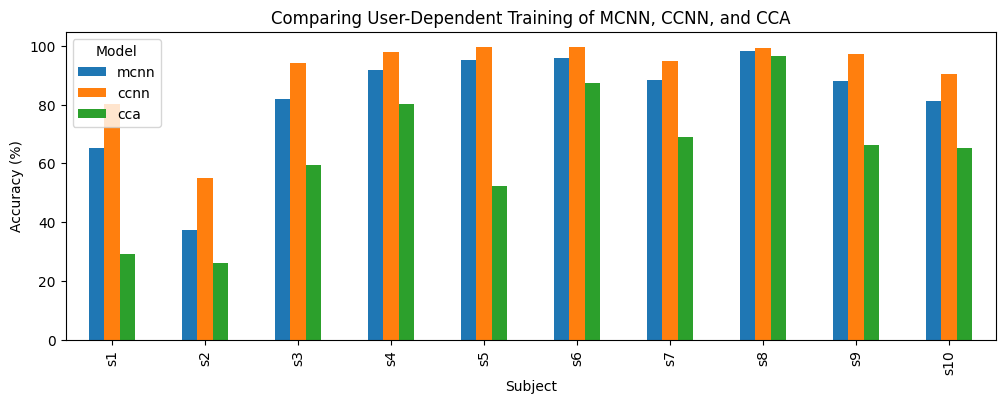

In [4]:
# create df for mcnn and ccnn
results = pd.DataFrame({
    'mcnn': np.fromiter(mcnn_results.values(), dtype=float), 
    'ccnn': np.fromiter(ccnn_results.values(), dtype=float)
}, index=mcnn_results.keys())

# add cca col
results['cca'] = np.fromiter(cca_results.values(), dtype=float)

# plot 
results.plot.bar(figsize=(12, 4), title='Comparing User-Dependent Training of MCNN, CCNN, and CCA')
plt.xlabel('Subject')
plt.ylabel('Accuracy (%)')
plt.legend(title="Model")
plt.show()

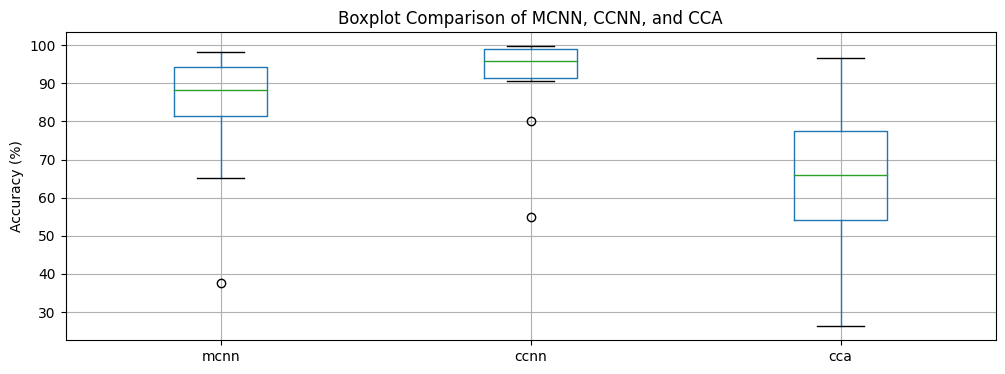

In [5]:
results.boxplot(figsize=(12, 4), column=['mcnn', 'ccnn', 'cca'])
plt.ylabel('Accuracy (%)')
plt.title('Boxplot Comparison of MCNN, CCNN, and CCA')
plt.show()